# exp021
特徴量追加

In [1]:
import os
import sys
import gc
import random
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify

In [2]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [3]:
@dataclass
class Cfg:
    exp_name = "exp021"
    seed = 42
    k = 20
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 1_000_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
random.seed(cfg.seed)

In [4]:
@noglobal
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.6
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [5]:
class Candidate:
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels

    def _entry(self, new_candidate_df, name, k):
        print(name)
        new_candidate_df[f"{name}_rank"] = new_candidate_df.groupby("session")["session"].cumcount()
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])
        
        self.output = self.output.merge(new_candidate_df, on=["session", "aid"], how="left")

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)

    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [6]:
@noglobal
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [7]:
@noglobal
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [8]:
@noglobal
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n, random_state=cfg.seed)])

In [9]:
class Features:
    def __init__(self, sessions, candidate):
        cfg = Cfg()
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id

    def add_features(self):
            self._prep()
            self._session_cnt()
            self._session_aid_nunique()
            self._session_last_type()
            self._session_last_dt()
            self._aid_cnt()
            self._session_mean_ts()
            self._aid_mean_ts()
            self._aid_cnt_ratio_at_session_last()
            
            self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    def _prep(self):
        print("prep")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    def _session_cnt(self):
        print("session_cnt")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

    def _session_aid_nunique(self):
        print("session_aid_nunique")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    def _session_last_type(self):
        print("session_last_type")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")

    def _session_last_dt(self):
        print("session_last_df")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")

    def _session_mean_ts(self):
        print("session_mean_ts")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")

    def _aid_mean_ts(self):
        print("aid_mean_ts")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    def _aid_session_nunique(self):
        print("aid_session_nunique")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    def _aid_cnt_ratio_at_session_last(self):
        print("aid_cnt_ratio_at_session_last")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.merge(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas(), on=["aid", f"session_last_{dt_}"], how="left")
            self.output[f"aid_cnt_ratio_at_session_last_{dt_}"] = self.output[f"aid_cnt_ratio_at_session_last_{dt_}"].fillna(0)

    def _aid_cnt(self):
        print("aid_cnt")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)     

In [10]:
@noglobal
def make_cand_df(sessions, labels=None, trans_maps=None):
    cfg = Cfg()

    if labels is not None:
         cand = Candidate(sessions)
    else:
        cand = Candidate(sessions, labels)

    cand.add(strategy="session_frequent", name="session_frequent")
    cand.add(strategy="session_latest", name="session_latest")
    cand.add(strategy="total_frequent", name="total_frequent")
    cand.add(strategy="session_frequent", trans_map=trans_maps["pair0"], name="session_frequent_pair")
    
    for i in range(5):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}")
      
    cand.add(strategy="session_frequent", trans_map=trans_maps["clicks_pair"], name="session_frequent_clicks_pair")
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks_pair"], name="session_latest_clicks_pair")
    # cand.add(strategy="session_frequent", trans_map=trans_maps["carts_pair"], name="session_frequent_carts_pair")
    cand.add(strategy="session_latest", trans_map=trans_maps["carts_pair"], name="session_latest_carts_pair")
    # cand.add(strategy="session_frequent", trans_map=trans_maps["orders_pair"], name="session_frequent_orders_pair")
    # cand.add(strategy="session_latest", trans_map=trans_maps["orders_pair"], name="session_latest_orders_pair")
    return cand.output

@noglobal
def add_features(sessions, cand_df):
    feat = Features(sessions, cand_df)
    feat.add_features()
    return feat.output.copy()

In [11]:
trans_maps = {}
pair_df_org = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix.pkl")
pair_df_org = pair_df_org[pair_df_org["cnt"] > 3].copy()
pair_df_org = pair_df_org.sort_values(["aid_x", "cnt"], ascending=(True, False))

for i in range(5):
    pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps[f"pair{str(i)}"] = pair_dict

pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks.pkl")
pair_df = pair_df[pair_df["cnt"] > 3].copy()
pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
trans_maps["clicks_pair"] = pair_dict

pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_carts.pkl")
pair_df = pair_df[pair_df["cnt"] > 3].copy()
pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
trans_maps["carts_pair"] = pair_dict

pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_orders.pkl")
pair_df = pair_df[pair_df["cnt"] > 3].copy()
pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
trans_maps["orders_pair"] = pair_dict

# trainデータ作成

In [12]:
report = f"\n{cfg.exp_name}\n"
report += f'train_start\n'
line_notify.send(report)

In [13]:
train_weeks = cfg.train_weeks
train_session_ids = []
dfs = []
for weeks in train_weeks:
    # データ読み込み
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{weeks}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{weeks}.pkl")
    train_session_ids.extend(week_sessions["session"].unique().tolist())

    # 候補選出
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)

    for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):    
        cand_df_type = cand_df.copy()
        # 正解追加・under sampling
        # cand_df_type = add_ground_truth_candidate(cand_df, week_labels, type_)
        cand_df_type = add_labels(cand_df_type, week_labels, type_)
        cand_df_type = under_sampling(cand_df_type, "labels")

        # 特徴量付与
        train_tmp = add_features(week_sessions, cand_df_type)
        train_tmp["type"] = type_int
        del cand_df_type
        gc.collect()
        dfs.append(train_tmp)
train = pd.concat(dfs)
train = train.reset_index(drop=True)
train_session_ids = list(set(train_session_ids))

del dfs, week_sessions, week_labels, cand_df
gc.collect()

session_frequent
session_latest
total_frequent
session_frequent_pair
session_latest_pair0
session_latest_pair1
session_latest_pair2
session_latest_pair3
session_latest_pair4
session_frequent_clicks_pair
session_latest_clicks_pair
session_latest_carts_pair
prep
session_cnt
session_aid_nunique
session_last_type
session_last_df
aid_cnt
session_mean_ts
aid_mean_ts
aid_cnt_ratio_at_session_last
prep
session_cnt
session_aid_nunique
session_last_type
session_last_df
aid_cnt
session_mean_ts
aid_mean_ts
aid_cnt_ratio_at_session_last
prep
session_cnt
session_aid_nunique
session_last_type
session_last_df
aid_cnt
session_mean_ts
aid_mean_ts
aid_cnt_ratio_at_session_last


0

# validデータ作成

In [14]:
valid_week = cfg.valid_week
dfs = []

# データ読み込み
week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
valid_session_ids = week_sessions["session"].unique().tolist()

# validに使うsessionを絞る (trainに存在するsessionを除外した上で設定した数に絞る)
valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
valid_session_ids = random.sample(valid_session_ids, valid_session_n)
week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()

# 候補選出
cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
# 特徴量付与
train_tmp = add_features(week_sessions, cand_df)

for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):
    train_tmp_type = train_tmp.copy()
    # ラベル付与
    train_tmp_type = add_labels(train_tmp_type, week_labels, type_)
    train_tmp_type["type"] = type_int
    dfs.append(train_tmp_type)
    del train_tmp_type
    gc.collect()
valid = pd.concat(dfs)
valid = valid.reset_index(drop=True)

del dfs, week_sessions, cand_df, train_tmp
gc.collect()

session_frequent
session_latest
total_frequent
session_frequent_pair
session_latest_pair0
session_latest_pair1
session_latest_pair2
session_latest_pair3
session_latest_pair4
session_frequent_clicks_pair
session_latest_clicks_pair
session_latest_carts_pair
prep
session_cnt
session_aid_nunique
session_last_type
session_last_df
aid_cnt
session_mean_ts
aid_mean_ts
aid_cnt_ratio_at_session_last


0

# 学習

In [15]:
target = "labels"
not_use_cols = ["session", "aid", target]
features = [c for c in train.columns if c not in not_use_cols]

In [16]:
params = {'objective': 'binary', 
          'boosting': 'gbdt', 
          'learning_rate': 0.1, 
          'metric': 'binary_logloss', 
          'seed': cfg.seed
          }

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 3312365, number of negative: 3312365
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 6624730, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.296492	valid_1's binary_logloss: 0.297595
[200]	training's binary_logloss: 0.293794	valid_1's binary_logloss: 0.293587
[300]	training's binary_logloss: 0.292656	valid_1's binary_logloss: 0.291824
[400]	training's binary_logloss: 0.291774	valid_1's binary_logloss: 0.290902
[500]	training's binary_logloss: 0.291071	valid_1's binary_logloss: 0.290327
[600]	training's binary_logloss: 0.290433

75

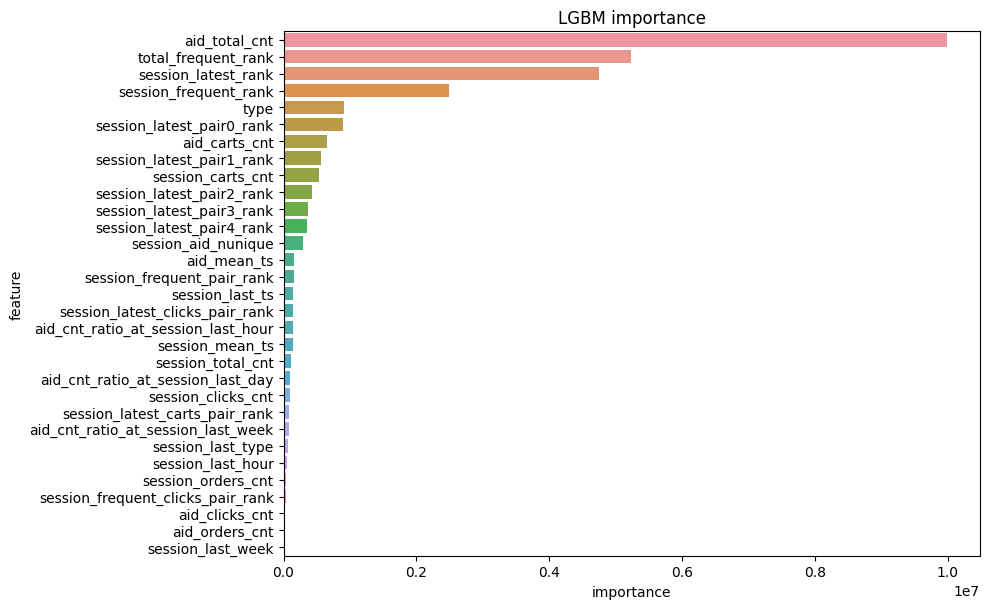

In [17]:
# 学習
vl_pred_df = valid[["session", "aid", "type"]].copy()

tr_x, tr_y = train[features], train[target]
vl_x, vl_y = valid[features], valid[target]
tr_data = lgb.Dataset(tr_x, label=tr_y)
vl_data = lgb.Dataset(vl_x, label=vl_y)

model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                  num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

# 特徴量重要度
fi = pd.DataFrame()
fi["feature"] = model.feature_name()
fi["importance"] = model.feature_importance(importance_type="gain")

# 2値分類の出力を元にk個選定
vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
vl_pred_df = vl_pred_df.sort_values(["session", "type", "prob"], ascending=(True, True, False))
vl_pred_df = vl_pred_df.groupby(["session", "type"]).head(cfg.k)
vl_pred_df = vl_pred_df.groupby(["session", "type"])["aid"].apply(list).reset_index()
vl_pred_df["type"] = vl_pred_df["type"].replace(cfg.id2type)

# 評価
assert week_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
score = evaluate(week_labels["clicks_labels"].tolist(),
                 week_labels["carts_labels"].tolist(),
                 week_labels["orders_labels"].tolist(),
                 vl_pred_df[vl_pred_df["type"]=="clicks"]["aid"].tolist(),
                 vl_pred_df[vl_pred_df["type"]=="carts"]["aid"].tolist(),
                 vl_pred_df[vl_pred_df["type"]=="orders"]["aid"].tolist(),
                 cfg.k)
print(score)

# モデル保存
model.save_model(cfg.output_dir + f"{cfg.exp_name}/model.lgb")

# 特徴量重要度
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

del train, valid, tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
del vl_pred_df, model
gc.collect()

In [18]:
report = f"\n{cfg.exp_name}\n"
report += f'valid_end\n'
report += str(score)
line_notify.send(report)

# sub

In [19]:
# testデータ作成
test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")

dfs =[]
# 候補選出
cand_df = make_cand_df(test_sessions, trans_maps=trans_maps)
# 特徴量付与
train_tmp = add_features(test_sessions, cand_df)

for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):    
    train_tmp_type = train_tmp.copy()
    train_tmp_type["type"] = type_int
    dfs.append(train_tmp_type)
test = pd.concat(dfs)
test = test.reset_index(drop=True)

del dfs, test_sessions, train_tmp, train_tmp_type
gc.collect()

session_frequent
session_latest
total_frequent
session_frequent_pair
session_latest_pair0
session_latest_pair1
session_latest_pair2
session_latest_pair3
session_latest_pair4
session_frequent_clicks_pair
session_latest_clicks_pair
session_latest_carts_pair
prep
session_cnt
session_aid_nunique
session_last_type
session_last_df
aid_cnt
session_mean_ts
aid_mean_ts
aid_cnt_ratio_at_session_last


9503

In [20]:
# 推論
model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/model.lgb")

# 2値分類の出力を元にk個選定
test["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
test = test.sort_values(["session", "type", "prob"], ascending=(True, True, False))
test = test.groupby(["session", "type"]).head(cfg.k)
test["aid"] = test["aid"].astype(str)
test = test.groupby(["session", "type"])["aid"].apply(list).reset_index()
test["aid"] = test["aid"].apply(lambda x: ' '.join(x))
test["type"] = test["type"].replace(cfg.id2type)

# sub作成
sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
test["session_type"] = test["session"].astype(str) + "_" + test["type"]
test = test.rename(columns={"aid": "labels"})
sub = sub.merge(test[["session_type", "labels"]], on="session_type", how="left")
sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)
sub.head(20)

,session_type,labels
0,12899779_clicks,59625 1130911 737445 894169 1854910 225209 108...
1,12899779_carts,59625 1130911 1854910 894169 737445 225209 496...
2,12899779_orders,59625 1130911 1854910 894169 225209 737445 688...
3,12899780_clicks,1142000 736515 889686 582732 973453 487136 150...
4,12899780_carts,1142000 889686 736515 582732 487136 973453 175...
5,12899780_orders,1142000 889686 736515 582732 973453 487136 175...
6,12899781_clicks,199008 918667 1681537 1628918 1460571 194067 5...
7,12899781_carts,918667 199008 1681537 1628918 759436 374037 52...
8,12899781_orders,199008 918667 1681537 1628918 759436 374037 19...
9,12899782_clicks,829180 479970 595994 834354 1007613 1033148 77...


In [21]:
report = f"\n{cfg.exp_name}\n"
report += f'inf_end\n'
line_notify.send(report)